In [3]:
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
#from collections import Counter
import random
from tqdm import tqdm
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import SpectralClustering

Here we present quickly four main steps in the spectral clustering. More details of the implementation of this method are presented in the acttached slide.

- Compute the Laplacian maxtrix based on the input matrix
- Compute the eigen values and eigen vectors of the Laplacian matrix
- Select n eigenvectors corresponding to the smallest eigen values and redefine the input space as n demensional subspace
- Find clusters in this subspace using various clustering algorithms, such as k-means

Create simulated data
--

we create a dataset with 7 clusters

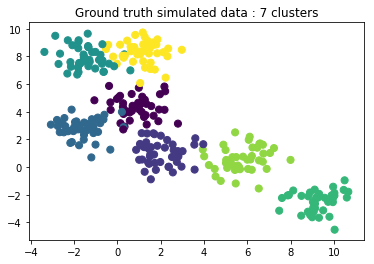

In [4]:
nb_clusters = 7
X, y_true = make_blobs(n_samples=300, centers=nb_clusters,
                       cluster_std=.80, random_state=0)

plt.title(f'Ground truth simulated data : {nb_clusters} clusters')
plt.scatter(X[:, 0], X[:, 1], s=50, c = y_true)

Applying the spectral Clustering on the simulated data
--

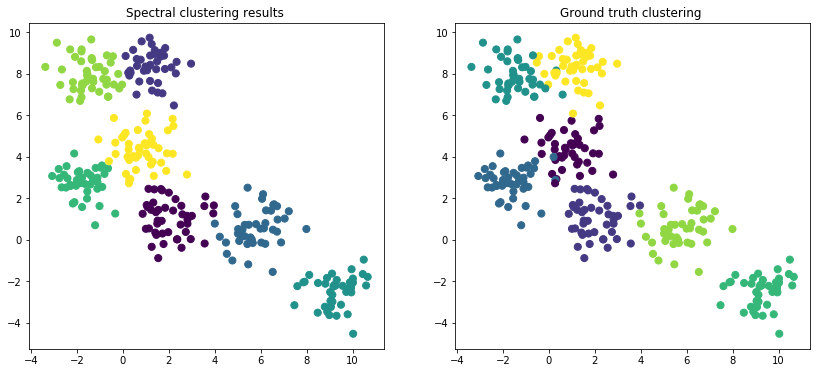

In [5]:
clustering = SpectralClustering(n_clusters=nb_clusters, assign_labels="discretize", random_state=0).fit(X)
y_pred = clustering.labels_
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.title(f'Spectral clustering results ')
plt.scatter(X[:, 0], X[:, 1], s=50, c = y_pred);

plt.subplot(122)
plt.title(f'Ground truth clustering ')
plt.scatter(X[:, 0], X[:, 1], s=50, c = y_true);

Spectral clustering is a technique known to perform well particularly in the case of non-gaussian clusters where the most common clustering algorithms such as K-Means fail to give good results. 

Applying the spectral clustering on the pyrat dataset
--

In [6]:
import pickle,scipy,os,tqdm
import ast
import numpy as np

- Load the pyrat dataset and convert it to the canvas. Here we consider two cases: The first case, the Python looses(assigning the output labels as 0) in the games and the second case the python don't loose in the games(draw or win)(assigning the output labels as 1).

- Here we consider the initial cheese distribution in the maze is the factor which decides the result of the games. And the pixel values in the maze used as the features for clustering.

In [7]:
mazeHeight = 15
mazeWidth = 21

# Convert a maze into a vector or canvas
def convert_input(maze, mazeWidth, mazeHeight, piecesOfCheese):
    im_size = (mazeWidth, mazeHeight) 
    canvas = np.zeros(im_size,dtype=np.int8)
    for (x_cheese,y_cheese) in piecesOfCheese:
        canvas[x_cheese,y_cheese] = 1
    # For use with sklearn, we flatten the matrix into an vector
    return canvas.ravel()

PHRASES = {
    "# Random seed\n": "seed",
    "# MazeMap\n": "maze",
    "# Pieces of cheese\n": "pieces"    ,
    "# Rat initial location\n": "rat"    ,
    "# Python initial location\n": "python"   , 
    "rat_location then python_location then pieces_of_cheese then rat_decision then python_decision\n": "play"
}
 
MOVE_DOWN = 'D'
MOVE_LEFT = 'L'
MOVE_RIGHT = 'R'
MOVE_UP = 'U'
 
translate_action = {
    MOVE_LEFT:0,
    MOVE_RIGHT:1,
    MOVE_UP:2,
    MOVE_DOWN:3
}
 
def process_file(filename):
    f = open(filename,"r")    
    info = f.readline()
    params = dict(play=list())
    while info is not None:
        if info.startswith("{"):
            params["end"] = ast.literal_eval(info)
            break
        if "turn " in info:
            info = info[info.find('rat_location'):]
        if info in PHRASES.keys():
            param = PHRASES[info]
            if param == "play":
                rat = ast.literal_eval(f.readline())
                python = ast.literal_eval(f.readline())
                pieces = ast.literal_eval(f.readline())
                rat_decision = f.readline().replace("\n","")
                python_decision = f.readline().replace("\n","")
                play_dict = dict(
                    rat=rat,python=python,piecesOfCheese=pieces,
                    rat_decision=rat_decision,python_decision=python_decision)
                params[param].append(play_dict)
            else:
                params[param] = ast.literal_eval(f.readline())
        else:
            print("did not understand:", info)
            break
        info = f.readline()
    return params

In [8]:

games = list()
directory = "saves/"
for root, dirs, files in os.walk(directory):
    for filename in tqdm.tqdm(files):
        try:
            if filename.startswith("."):
                continue
            game_params = process_file(directory+filename)
            games.append(game_params)
        except:
            print("Filename {} did not work".format(filename))
            
x = np.array([]).reshape(0,mazeWidth * mazeHeight)
y = np.array([]).reshape(0,1)
wins_python = 0
wins_rat = 0
for game in tqdm.tqdm(games):
    if game["end"]["win_python"] == 1: 
        wins_python += 1
    elif game["end"]["win_rat"] == 1:
        wins_rat += 1    
    canvas = convert_input(game["maze"], mazeWidth, mazeHeight, game["play"][0]["piecesOfCheese"])
    if game["end"]["win_python"] == 1:
        y = np.append(y,1)
    elif game["end"]["win_rat"] == 1:
        y = np.append(y,-1)
        #y = np.append(y,0)
    else:
        y = np.append(y,0)
    x = np.concatenate([x, canvas.reshape(1,-1)], axis=0)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:19<00:00, 255.63it/s]


In [10]:
# SAVE x AND y IN A NPZ FILE
filename = 'pyrat_dataset_project2.npz'
np.savez(filename,x,y)

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split

dataset_npz = np.load('pyrat_dataset_project2.npz')
#print(np.shape(dataset_npz))
x_py = dataset_npz['arr_0']
y_py = dataset_npz['arr_1']

Applying the mean represenation in two cases (the python looses, the python don't looses)

In [18]:
# An array containing the mazes when the python looses
x_py_looses = x_py[np.where(y_py == -1)]
y_py_looses = y_py[np.where(y_py == -1)]
x_py_looses_mean = np.mean(x_py_looses.reshape(np.shape(x_py_looses)[0],21,15),axis = 0)
# An array containging the mazes when the python wins
x_py_wins = x_py[np.where(y_py == 1)]
y_py_wins = y_py[np.where(y_py == 1)]
x_py_wins_mean = np.mean(x_py_wins.reshape(np.shape(x_py_wins)[0],21,15),axis = 0)
# An array containging the mazes when the python draw
x_py_draws = x_py[np.where(y_py == 0)]
y_py_draws = y_py[np.where(y_py == 0)]
x_py_draws_mean = np.mean(x_py_draws.reshape(np.shape(x_py_draws)[0],21,15),axis = 0)

x_py_mean = np.concatenate((x_py_looses_mean.reshape(1,315),x_py_wins_mean.reshape(1,315),x_py_draws_mean.reshape(1,315)))
titles = (['Python looses'],['Python wins'],['Python draws'])

Plot the mean representation for two cases

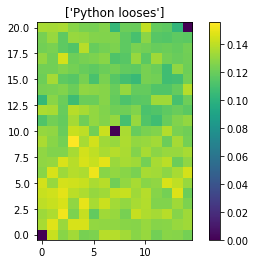

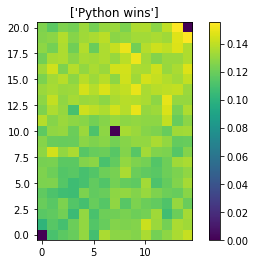

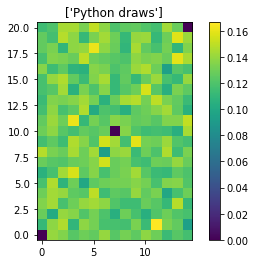

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(3):
    plt.imshow(x_py_mean[i].reshape((21,15)))
    plt.title(titles[i])
    plt.gca().invert_yaxis()
    plt.colorbar()
    plt.show()

The results show that when the cheese density distribution is near to the python so, the python has more chance to win than the rat and inversely. And when the cheese density equally distributes between the python and the rat, the game will be drawing.

Using the spectral clustering method for pyrat dataset (n_clusters = 3)
--

In [20]:
from sklearn.cluster import SpectralClustering

Clustering by using the sklearn libary

In [26]:
model = SpectralClustering(n_clusters=3, affinity='nearest_neighbors',
                          assign_labels='kmeans')
clustering = model.fit(x_py)
affinity_matrix= clustering.affinity_matrix_
labels = clustering.labels_

In [27]:
labels

array([2, 1, 0, ..., 0, 0, 2])

- In the case of using spectral clustering, we can't get the centroids of each cluster. In the theory, we know that the real data points (the pixel values) are embedded into the low dimensional space (spectral embedding) in which the clusters are more obvious which the use of the eingenvectors of the Laplacian matrix. Then we use the classical K-means algorithm to partion the embedding.

- To make the results more visual. After retreiving each cluster, we get the cluster's centroids (a non usual way) by calculating the mean value of all the elements of each cluster.

In [30]:
print(labels)
cluster_0 = x_py[np.where(labels == 0)]
print(np.shape(cluster_0))
cluster_1 = x_py[np.where(labels == 1)]
print(np.shape(cluster_1))
cluster_2 = x_py[np.where(labels == 2)]
print(np.shape(cluster_2))

cluster_0_mean = np.mean(cluster_0.reshape(np.shape(cluster_0)[0],21,15),axis = 0)
cluster_1_mean = np.mean(cluster_1.reshape(np.shape(cluster_1)[0],21,15),axis = 0)
cluster_2_mean = np.mean(cluster_2.reshape(np.shape(cluster_2)[0],21,15),axis = 0)

spectralClustering_centroids = np.concatenate((cluster_0_mean.reshape(1,315),cluster_1_mean.reshape(1,315),cluster_2_mean.reshape(1,315)))
titles = (['Cluster 0'],['Cluster 1'],['cluster 2'])


[2 1 0 ... 0 0 2]
(1854, 315)
(1938, 315)
(1208, 315)


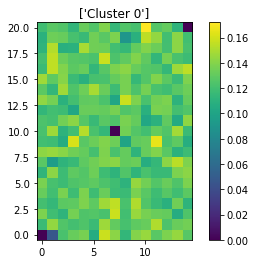

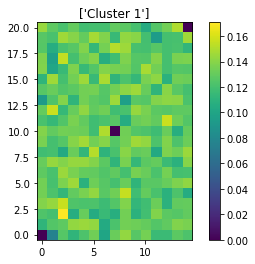

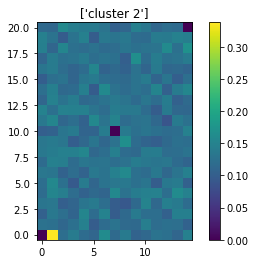

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(3):
    plt.imshow(spectralClustering_centroids[i].reshape((21,15)))
    plt.title(titles[i])
    plt.gca().invert_yaxis()
    plt.colorbar()
    plt.show()

We can see that the spectral clustering algorithm don't work well with the pyrat dataset, when the input is the matrix [N*d] when N = 5000 examples and d = 315 dimensions.

Finding an optimal number of cluster of the spectral clustering (Self-tuning Spectral Clustering)
--

- The idea behind the self tuning spectral clustering is determine the optimal number of clusters and also the similarity metric σi used in the computation of the affinity matrix (Self-Tuning Spectral Clustering- Lihi Zelnik-Manor and Pietro Perona)

- In the paper "a tutorial on spectral clustering — ulrike von luxburg" Eigengap heuristic suggests the number of clusters k is usually given by the value of k that maximizes the eigengap (difference between consecutive eigenvalues). The larger this eigengap is, the closer the eigenvectors of the ideal case and hence the better spectral clustering works.

In [32]:
from scipy.spatial.distance import pdist, squareform
def getAffinityMatrix(coordinates, k):
    """
    Calculate affinity matrix based on input coordinates matrix and the numeber
    of nearest neighbours.
    
    Apply local scaling based on the k nearest neighbour
        References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    """
    # calculate euclidian distance matrix
    dists = squareform(pdist(coordinates)) 
    
    # for each row, sort the distances ascendingly and take the index of the 
    #k-th position (nearest neighbour)
    knn_distances = np.sort(dists, axis=0)[k]
    knn_distances = knn_distances[np.newaxis].T
    
    # calculate sigma_i * sigma_j
    local_scale = knn_distances.dot(knn_distances.T)

    affinity_matrix = dists * dists
    affinity_matrix = -affinity_matrix / local_scale
    # divide square distance matrix by local scale
    affinity_matrix[np.where(np.isnan(affinity_matrix))] = 0.0
    # apply exponential
    affinity_matrix = np.exp(affinity_matrix)
    np.fill_diagonal(affinity_matrix, 0)
    return affinity_matrix

In [33]:
import scipy
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh
def eigenDecomposition(A, plot = True):
    """
    :param A: Affinity matrix
    :param plot: plots the sorted eigen values for visual inspection
    :return A tuple containing:
    - the optimal number of clusters by eigengap heuristic
    - all eigen values
    - all eigen vectors
    
    This method performs the eigen decomposition on a given affinity matrix,
    following the steps recommended in the paper:
    1. Construct the normalized affinity matrix: L = D−1/2ADˆ −1/2.
    2. Find the eigenvalues and their associated eigen vectors
    3. Identify the maximum gap which corresponds to the number of clusters
    by eigengap heuristic
    
    References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    http://www.kyb.mpg.de/fileadmin/user_upload/files/publications/attachments/Luxburg07_tutorial_4488%5b0%5d.pdf
    """
    L = csgraph.laplacian(A, normed=True)
    n_components = A.shape[0]
    
    # LM parameter : Eigenvalues with largest magnitude (eigs, eigsh), that is, largest eigenvalues in 
    # the euclidean norm of complex numbers.
    eigenvalues, eigenvectors = eigsh(L, k=n_components, which="LM", sigma=1.0, maxiter=5000)
    
    if plot:
        plt.title('Largest eigen values of input matrix')
        plt.scatter(np.arange(len(eigenvalues)), eigenvalues)
        plt.grid()
        
    # Identify the optimal number of clusters as the index corresponding
    # to the larger gap between eigen values
    index_largest_gap = np.argmax(np.diff(eigenvalues))
    nb_clusters = index_largest_gap + 1
        
    return nb_clusters, eigenvalues, eigenvectors

C:\Users\vankh\Anaconda3\lib\site-packages\scipy\sparse\linalg\eigen\arpack\arpack.py:1556: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  RuntimeWarning)


Optimal number of clusters 1


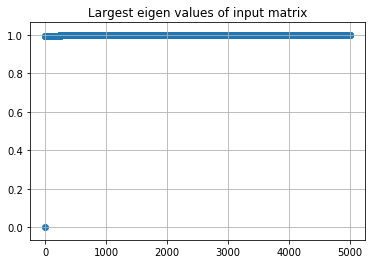

In [34]:
affinity_matrix = getAffinityMatrix(x_py, k = 20)
k, _,  _ = eigenDecomposition(affinity_matrix)
print(f'Optimal number of clusters {k}')

By using two methods proposed, we find the optimal number of cluster of our dataset is 1. When we cluster our dataset with 3 clusters, it doesn't show a good result. But actually, with the grounth truth we can see easily there are 3 possible cases for the python. So in our opinion, the problem is the dimension of our dataset is quitely high compared with the number of the samples.

References
--

- Spectral graph clustering and optimal number of clusters estimation at https://towardsdatascience.com/spectral-graph-clustering-and-optimal-number-of-clusters-estimation-32704189afbe

- Spectral Clustering at https://towardsdatascience.com/spectral-clustering-aba2640c0d5b